✅ Script is running...
Using device: cpu
Epoch 1: Train Loss = 0.6752, Test Loss = 0.5917, Accuracy = 77.35%
Epoch 2: Train Loss = 0.3651, Test Loss = 0.3488, Accuracy = 86.04%
Epoch 3: Train Loss = 0.2664, Test Loss = 0.2820, Accuracy = 88.48%
Epoch 4: Train Loss = 0.1953, Test Loss = 0.2122, Accuracy = 91.91%
Epoch 5: Train Loss = 0.1505, Test Loss = 0.2233, Accuracy = 92.60%
Epoch 6: Train Loss = 0.1190, Test Loss = 0.1380, Accuracy = 95.12%
Epoch 7: Train Loss = 0.0837, Test Loss = 0.1700, Accuracy = 94.58%
Epoch 8: Train Loss = 0.0672, Test Loss = 0.1523, Accuracy = 94.66%
Epoch 9: Train Loss = 0.0585, Test Loss = 0.1336, Accuracy = 95.96%
Epoch 10: Train Loss = 0.0543, Test Loss = 0.1557, Accuracy = 95.80%
Epoch 11: Train Loss = 0.0669, Test Loss = 0.1151, Accuracy = 96.64%
Epoch 12: Train Loss = 0.0367, Test Loss = 0.1018, Accuracy = 97.64%
Epoch 13: Train Loss = 0.0385, Test Loss = 0.1294, Accuracy = 96.41%
Epoch 14: Train Loss = 0.0446, Test Loss = 0.0929, Accuracy = 97.94%
Ep

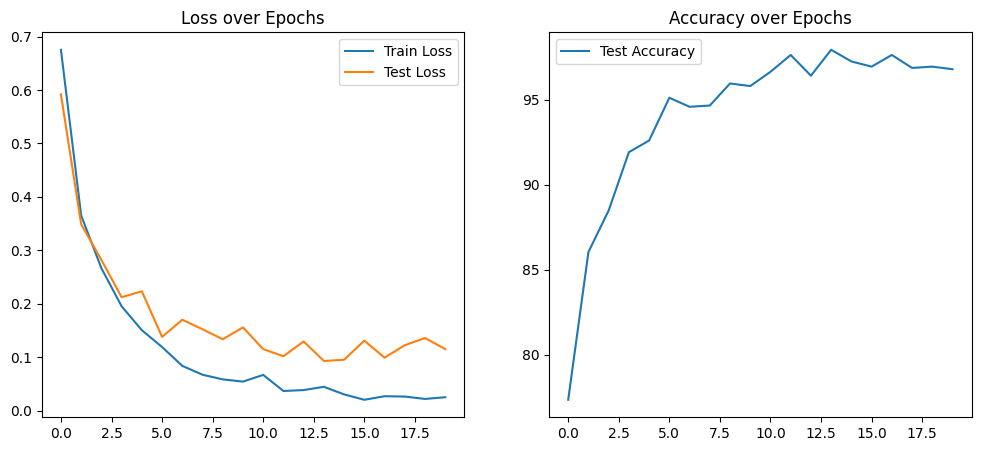

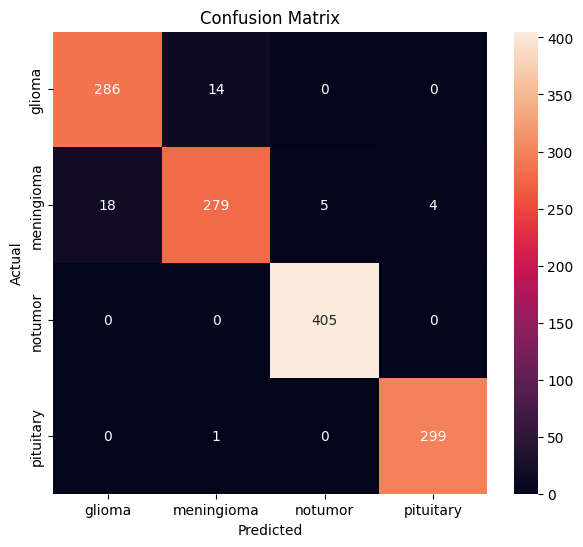


Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.95      0.95       300
  meningioma       0.95      0.91      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

Predicted class: notumor


'notumor'

In [3]:
print("✅ Script is running...")
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Device config
device = torch.device("cpu")
print("Using device:", device)

# Paths (update if needed)
train_dir = r"C:\Users\saima\OneDrive\Desktop\Documents\brain_tumor_cnn_project\dataset\Training"
test_dir = r"C:\Users\saima\OneDrive\Desktop\Documents\brain_tumor_cnn_project\dataset\Testing"

# Transforms
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Datasets
train_data = ImageFolder(train_dir, transform=transform)
test_data = ImageFolder(test_dir, transform=transform)
class_names = train_data.classes

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self._to_linear = None
        self._get_flattened_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)  # 4 classes
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 150, 150)
            x = self.cnn_layers(x)
            self._to_linear = x.numel()

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = BrainTumorCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Test
    model.eval()
    correct, total = 0, 0
    test_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Accuracy = {accuracy:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
        print(f"Predicted class: {predicted_class}")
        return predicted_class

# Example usage
image_path = r"C:\Users\saima\OneDrive\Desktop\Documents\brain_tumor_cnn_project\sample_image\Te-no_0021.jpg"
predict_image(image_path, model, transform, class_names)
